In [5]:
!python3 -m pip install matplotlib
!python3 -m pip install seaborn
!python3 -m pip install kneed

# The purpose of this python file is to run k means on five variables: age of diagnosis, bmi, HbA1c, fasting insulin, and fasting glucose
# load libraries
import pandas as pd 
import numpy as np
import os as os

import sklearn as sklearn

import matplotlib.pyplot as plt
import seaborn as sns
from kneed import KneeLocator
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

if os.getlogin() == "JVARGH7":
    path_nhanes_ckm_folder = "C:/Cloud/OneDrive - Emory University/Papers/NHANES Subtypes Mortality"
elif os.getlogin() == 'JGUO258':
    path_nhanes_ckm_folder = "C:/Users/JGUO258/OneDrive - Emory/NHANES CKM Cascade"
elif os.getlogin() == 'ksanaka':
    path_nhanes_ckm_folder = "/Users/ksanaka/Library/CloudStorage/OneDrive-Emory/NHANES CKM Cascade"
elif os.getlogin() == 'root':
    path_nhanes_ckm_folder = "/Users/ksanaka/Library/CloudStorage/OneDrive-Emory/NHANES CKM Cascade"

# Load the dataset
analytic_dataset = pd.read_csv(path_nhanes_ckm_folder + '/working/new diabetes/knn imputation.csv') 

#----------------------------------------------------------------------------------------------------------------------------------
# cluster variables: "bmi","dm_age","glycohemoglobin","HOMA2 %B","HOMA2 IR"

# List of columns to keep
columns_to_keep = ['dm_age', 'bmi', 'glycohemoglobin', 'homa2b', 'homa2ir', 'ldl', 'hdl', 'triglyceride', 'alt', 'ast', 'sbp', 'dbp', 'egfr', 'waistcircumference']

# Select only the columns you want to keep
analytic_dataset_cluster = analytic_dataset[columns_to_keep].copy()

# Capture the columns that were not used for clustering
other_vars = analytic_dataset.drop(columns=columns_to_keep)

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(analytic_dataset[['bmi','dm_age','glycohemoglobin','homa2b', 'homa2ir']])

data_scaled = pd.DataFrame(data_scaled, columns=['bmi','dm_age','glycohemoglobin','homa2b', 'homa2ir'])


# Perform KMeans clustering
kmeans = KMeans(init="random", n_clusters=4, n_init=10, max_iter=300, random_state=57)
kmeans.fit(data_scaled)

# Add cluster labels to the original dataset with selected columns
analytic_dataset_cluster['cluster'] = kmeans.labels_


Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


In [6]:
kmeans_kwargs = { # set the parameters for the kmeans algorithm
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 57,
}

# A list holds the SSE values for each k
sse = [] #initiate an empty list to store the sum of squared errors 
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(data_scaled)
    sse.append(kmeans.inertia_)

# Determining the elbow point in the SSE curve isn’t always straightforward. 
# If you’re having trouble choosing the elbow point of the curve, then you could use a Python package:
# kneed, to identify the elbow point programmatically:

kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")
print("Elbow point:" + str(kl.elbow)) # returns the elbow point
cluster_summary = analytic_dataset_cluster.groupby('cluster').describe()
print(cluster_summary)
data_to_plot = analytic_dataset_cluster[columns_to_keep + ['cluster']]

Elbow point:3
         dm_age                                                         \
          count       mean        std   min   25%    50%    75%    max   
cluster                                                                  
0         258.0  52.419574   9.771916  17.0  47.0  52.75  59.00  77.00   
1         623.0  48.983547   9.480202  17.0  43.0  50.00  56.00  71.00   
2        1281.0  62.687744   9.196657  26.0  56.5  62.25  68.75  85.00   
3         278.0  54.782374  10.954630  18.0  49.0  55.25  62.00  81.25   

            bmi             ...        egfr             waistcircumference  \
          count       mean  ...         75%         max              count   
cluster                     ...                                              
0         258.0  31.688760  ...  118.473846  170.122803              258.0   
1         623.0  39.656148  ...  112.203931  155.803924              623.0   
2        1281.0  28.876924  ...   95.924512  153.063349             1281.0   

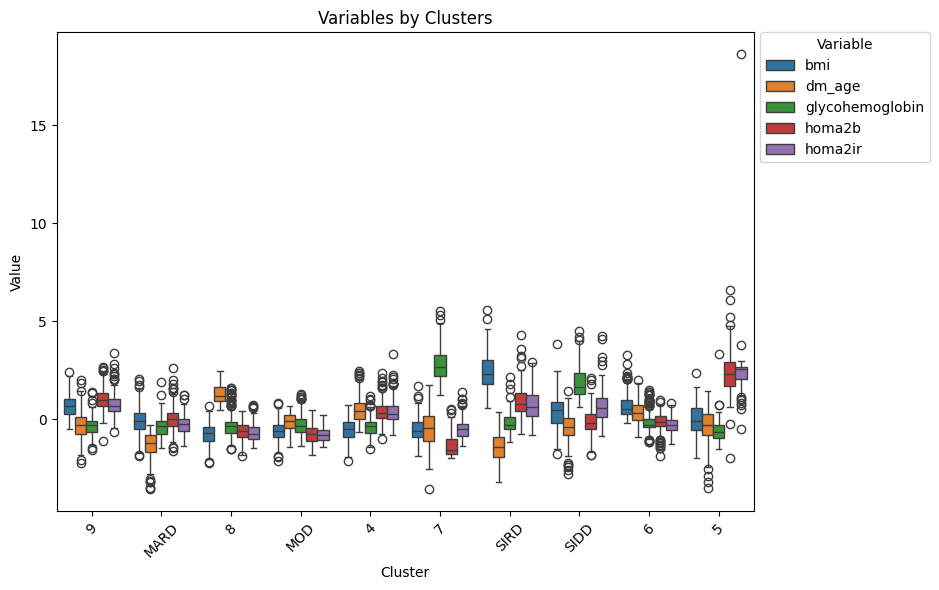

<Figure size 640x480 with 0 Axes>

In [7]:


# Relabel the cluster labels based on clinical characteristics
analytic_dataset_cluster['cluster'] = analytic_dataset_cluster['cluster'].replace({0:'SIDD', 1:'MOD', 2:'MARD', 3:'SIRD'})

# Concatenate the other variables back to the dataset
analytic_dataset_cluster = pd.concat([analytic_dataset_cluster, other_vars], axis=1)

# Check the final counts for each cluster
analytic_dataset_cluster['cluster'].value_counts()

# Save the dataset with the cluster labels
analytic_dataset_cluster.to_csv(path_nhanes_ckm_folder + '/working/new diabetes/knn clusters.csv', index=False)

#----------------------------------------------------------------------------------------------------------------------------------------------
# Plot the clusters
# Add the cluster labels to the copy of the scaled data

data_scaled_cluster = data_scaled.copy()
data_scaled_cluster['cluster'] = kmeans.labels_

# Relabel the cluster labels
data_scaled_cluster['cluster'] = data_scaled_cluster['cluster'].replace({0:'SIDD', 1:'MOD', 2:'MARD', 3:'SIRD'})

# Create a new DataFrame with the cluster assignments and variables
data_clustered = pd.concat([data_scaled_cluster['cluster'], data_scaled_cluster[['bmi','dm_age','glycohemoglobin','homa2b','homa2ir']]], axis=1)

# Melt the DataFrame to convert it into long format
data_melted = data_clustered.melt(id_vars='cluster', var_name='Variable', value_name='Value')

# Create the boxplot
plt.figure(figsize=(9.5, 6))  # Adjusted figure size for better layout
sns.boxplot(x='cluster', y='Value', hue='Variable', data=data_melted)
plt.title('Variables by Clusters')
plt.xlabel('Cluster')
plt.ylabel('Value')
plt.xticks(rotation=45)

# Move the legend to the right of the plot
plt.legend(title='Variable', bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

plt.tight_layout()  # Adjust the layout to make room for the legend
plt.show()

# Save the plot to a file
plt.savefig(path_nhanes_ckm_folder + '/figures/boxplot_clusters.png', format='png', dpi=300, bbox_inches='tight')